In [1]:
%matplotlib inline

import sys
PATH = '/Users/francescogemignani/Desktop/fma-proj'
sys.path.insert(0, PATH) 

# libraries for imbalanced learning
from imblearn.under_sampling import RandomUnderSampler,CondensedNearestNeighbour, TomekLinks
from imblearn.over_sampling import RandomOverSampler, SMOTE,KMeansSMOTE, ADASYN
from fma_metadata import utils
import pandas as pd
import numpy as np

# sklearn modules
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, classification_report, recall_score,precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier

import plotly.express as px
import matplotlib.pyplot as plt

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

# Librosa features - IMBALANCED LEARNING


## 1. Premise
The hyper-parameters and results for unbalanced classifiers are taken  from the notebooks:
- multi-genre_classification-features

Since in our previous analysis we found out that Decision Tree had higher performances with feature selection, we decided to improve our results starting from those classifiers.

__________________________________
## 2. Multi genre classification
__________________________________
## Import dataset

In [2]:
multiclass_dataset = pd.read_csv('/Users/francescogemignani/Google Drive/DM2/_FMA/fma_metadata/anomaly_detection-librosa.csv')
multiclass_dataset.set_index('track_id',inplace=True)
multiclass_dataset.head()

#genres_subset = ['Rock','Electronic','Hip-Hop','Folk','Old-Time / Historic','Pop','Classical','Jazz']
#multiclass_dataset = multiclass_dataset[ multiclass_dataset['genre_top'].isin(genres_subset)]
#print(f"Librosa features anomaly free - top 8 genres: {multiclass_dataset.shape}")

('chroma_cens', 'kurtosis', '01')  \
track_id                                      
2                                  7.180653   
3                                  1.888963   
5                                  0.527563   
134                                0.918445   
135                                0.978402   

          ('chroma_cens', 'kurtosis', '02')  \
track_id                                      
2                                  5.230309   
3                                  0.760539   
5                                 -0.077654   
134                                0.674147   
135                                0.623572   

          ('chroma_cens', 'kurtosis', '03')  \
track_id                                      
2                                  0.249321   
3                                  0.345297   
5                                 -0.279610   
134                                0.577818   
135                                1.129261   

          ('chroma_cens', 'kurtosis', '04')  \
track_id                                      
2                                  1.347620   
3                                  2.295201   
5                                  0.685883   
134                                1.281117   
135                               -1.043970   

          ('chroma_cens', 'kurtosis', '05')  \
track_id                                      
2                                  1.482478   
3                                  1.654031   
5                                  1.937570   
134                                0.933746   
135                               -1.127288   

          ('chroma_cens', 'kurtosis', '06')  \
track_id                                      
2                                  0.531371   
3                                  0.067592   
5                                  0.880839   
134                                0.078177   
135                               -0.032642   

          ('chroma_cens', 'kurtosis', '07')  \
track_id                                      
2                                  1.481593   
3                                  1.366848   
5                                 -0.923192   
134                                1.199204   
135                               -0.878434   

          ('chroma_cens', 'kurtosis', '08')  \
track_id                                      
2                                  2.691455   
3                                  1.054094   
5                                 -0.927232   
134                               -0.175223   
135                               -0.916234   

          ('chroma_cens', 'kurtosis', '09')  \
track_id                                      
2                                  0.866868   
3                                  0.108103   
5                                  0.666617   
134                                0.925482   
135                               -0.743257   

          ('chroma_cens', 'kurtosis', '10')  ...  ('tonnetz', 'std', '05')  \
track_id                                     ...                             
2                                  1.341231  ...                  0.012226   
3                                  0.619185  ...                  0.014212   
5                                  1.038546  ...                  0.012691   
134                                1.438509  ...                  0.016322   
135                                0.609235  ...                  0.016731   

          ('tonnetz', 'std', '06')  ('zcr', 'kurtosis', '01')  \
track_id                                                        
2                         0.012111                   5.758890   
3                         0.017740                   2.824694   
5                         0.014759                   6.808415   
134                       0.015819                   4.731087   
135                       0.020464                  -0.038451   

          ('zcr', 'max', '01')  ('zcr

In [3]:
multiclass_dataset.shape

(33373, 519)

In [4]:
multiclass_dataset['genre_top'].unique()

array(['Hip-Hop', 'Rock', 'Folk', 'Jazz', 'Pop', 'Electronic',
       'Classical', 'Old-Time / Historic'], dtype=object)

[]

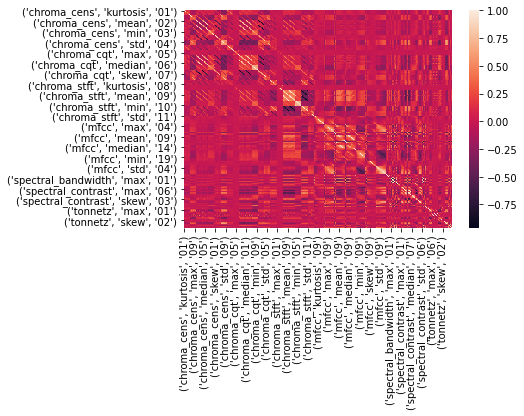

In [5]:
corr = multiclass_dataset.corr()
sns.heatmap(corr)
plt.plot()

In [6]:
# check class distribution in before balancing
pd.concat([multiclass_dataset.genre_top.value_counts(),
                round(multiclass_dataset.genre_top.value_counts(normalize=True).mul(100),2)],
          axis=1,
          keys=('counts','percentage (%)'))

counts  percentage (%)
Rock                  13955           41.82
Electronic             8748           26.21
Hip-Hop                3447           10.33
Folk                   2741            8.21
Pop                    2180            6.53
Classical              1203            3.60
Jazz                    550            1.65
Old-Time / Historic     549            1.65

In [7]:
# Data preprocessing

# labels encoding
le = preprocessing.LabelEncoder()
multiclass_dataset['genre_top'] = le.fit_transform(multiclass_dataset['genre_top'])
print('Legend:\n0: Classical\n1: Electronic\n2: Folk\n3: Hip-Hop\n4: Jazz\n5: Old-Time / Historic\n6: Pop\n7: Rock')

# detach target col
labels = multiclass_dataset[['genre_top']]
labels.reset_index(drop=True, inplace=True)
labels = labels['genre_top']

Legend:
0: Classical
1: Electronic
2: Folk
3: Hip-Hop
4: Jazz
5: Old-Time / Historic
6: Pop
7: Rock


In [8]:
# remove labels from dataset
multiclass_dataset.drop('genre_top', axis=1, inplace=True)

In [9]:
# normalize data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(multiclass_dataset)
scaled_features.shape

(33373, 518)

# A) PCA: Multigenre Classification

## A.1) Compute PCA and plot distribution in 2D

In [38]:
# compute PCA using optimal number of components: 154 ( discovered in the notebook mentioned above)
pca = PCA(154,random_state=10)
pca.fit(scaled_features)
X_pca = pca.transform(scaled_features)


In [39]:
# split data in development and internal test
X, X_test, y, y_test = train_test_split(X_pca, labels, test_size=0.30, random_state=10, stratify=labels)

In [40]:
# development set shape
X.shape, y.shape

((23361, 154), (23361,))

In [41]:
# internal test shape
X_test.shape, y_test.shape

((10012, 154), (10012,))

In [42]:
print(f"____Legend_____\n0: Classical\n1: Electronic\n2: Folk\n3: Hip-Hop\n4: Jazz\n5: Old-Time / Historic\n6: Pop\
\n7: Rock'\n")

print('Class distribution before balancing after splitting in train test')
pd.concat(
    [y.value_counts(),
                round(y.value_counts(normalize=True).mul(100),2)],
                axis=1,
                keys=('counts','percentage (%)')
)

____Legend_____
0: Classical
1: Electronic
2: Folk
3: Hip-Hop
4: Jazz
5: Old-Time / Historic
6: Pop
7: Rock'

Class distribution before balancing after splitting in train test


counts  percentage (%)
7    9768           41.81
1    6124           26.21
3    2413           10.33
2    1919            8.21
6    1526            6.53
0     842            3.60
4     385            1.65
5     384            1.64

In [43]:
print(f"____Legend_____\n0: Classical\n1: Electronic\n2: Folk\n3: Hip-Hop\n4: Jazz\n5: Old-Time / Historic\n6: Pop\
\n7: Rock'\n")

print('Class distribution before balancing after splitting in test test')
pd.concat(
    [y_test.value_counts(),
                round(y_test.value_counts(normalize=True).mul(100),2)],
                axis=1,
                keys=('counts','percentage (%)')
)

____Legend_____
0: Classical
1: Electronic
2: Folk
3: Hip-Hop
4: Jazz
5: Old-Time / Historic
6: Pop
7: Rock'

Class distribution before balancing after splitting in test test


counts  percentage (%)
7    4187           41.82
1    2624           26.21
3    1034           10.33
2     822            8.21
6     654            6.53
0     361            3.61
5     165            1.65
4     165            1.65

In [10]:
# function for plotting data in 2D with PCA
def pca_2D(X, y, graph_title):
    """
    This function plots in 2D the features of X.
    :param X: array of features
    :param y: labels
    :param graph_title: title to be displayed on the graph
    :return: 2D scatter-plot
    """
    # dataframe for plotting PCA
    df = pd.DataFrame()
    df['pca1'] = X[:,0]
    df['pca2'] = X[:,1]
    df['genres'] = le.inverse_transform(y)
    # plot scatter of PCA
    plt.figure(figsize=(10,7))
    sns.scatterplot(
        x="pca1", y="pca2",
        hue='genres',
        data=df,
        palette={'Jazz':'mediumorchid','Rock':'forestgreen', 'Hip-Hop':'dodgerblue',
                 'Pop':'darkorange', 'Electronic':'saddlebrown','Old-Time / Historic':'grey',
                 'Folk':'crimson', 'Classical':'violet'},
        legend="full",
        alpha=0.8
    )
    plt.title(graph_title, fontsize= 15)
    plt.show()

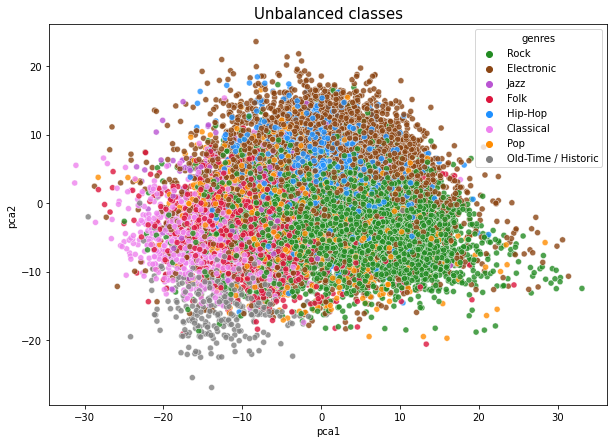

In [45]:
pca_2D(X, y,'Unbalanced classes')

## A.2) Imbalanced learning

In [46]:
print(f"____Legend_____\n0: Classical\n1: Electronic\n2: Folk\n3: Hip-Hop\n4: Jazz\n5: Old-Time / Historic\n6: Pop\
\n7: Rock'\n\n Class distribution after Random Undersampling")

____Legend_____
0: Classical
1: Electronic
2: Folk
3: Hip-Hop
4: Jazz
5: Old-Time / Historic
6: Pop
7: Rock'

 Class distribution after Random Undersampling


#### A.2.1) Undersampling - Random

In [48]:
under_sample = RandomUnderSampler(random_state=42)
# Store under-sampled data
X_under, y_under = under_sample.fit_resample(X,y)

In [49]:
y_under.value_counts()

7    384
5    384
3    384
1    384
6    384
4    384
2    384
0    384
Name: genre_top, dtype: int64

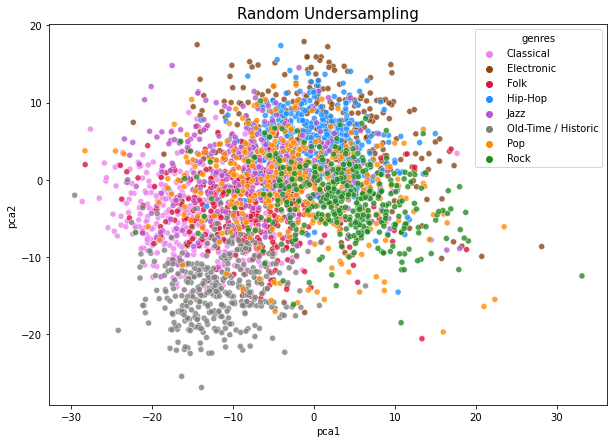

In [50]:
pca_2D(X_under,y_under,'Random Undersampling')

#### A.2.2) Condensed Nearest Neighbor (CNN) *

In [53]:
# Apply Condensed Nearest Neighbours
cnn = CondensedNearestNeighbour(sampling_strategy='not minority')
X_cnn, y_cnn = cnn.fit_resample(X, y)
#X_res_vis = pca.transform(X_resampled)

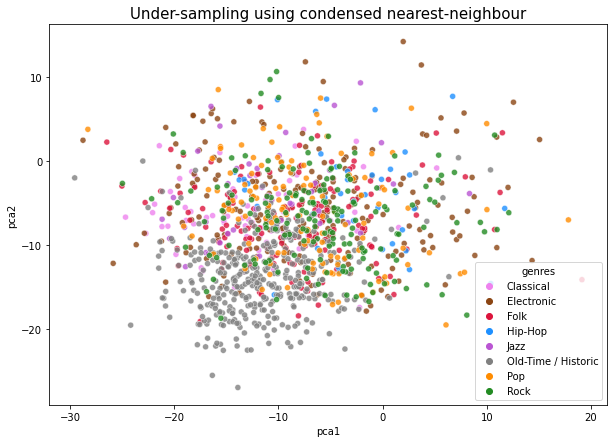

In [54]:
pca_2D(X_cnn,y_cnn,'Under-sampling using condensed nearest-neighbour')

In [55]:
y_cnn.value_counts()

5    384
1    210
7    171
2    147
6    118
0     68
3     44
4     43
Name: genre_top, dtype: int64

#### A.2.3) Tomek's Link *

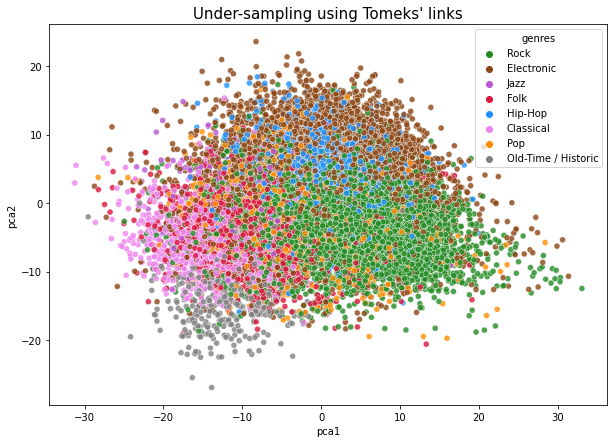

In [56]:
# with not minority works as cnn
class2sample = [0,1,2,3,4,6,7]
tomeks = TomekLinks(sampling_strategy=class2sample)
X_tomek, y_tomek = tomeks.fit_resample(X, y)
pca_2D(X_tomek, y_tomek, 'Under-sampling using Tomeks\' links')

In [57]:
y_tomek.value_counts()

7    9614
1    5978
3    2317
2    1857
6    1437
0     832
5     384
4     367
Name: genre_top, dtype: int64

#### A.2.4) Oversampling - Random

In [58]:
over_sample = RandomOverSampler(sampling_strategy='not majority')
X_over, y_over = over_sample.fit_resample(X, y)

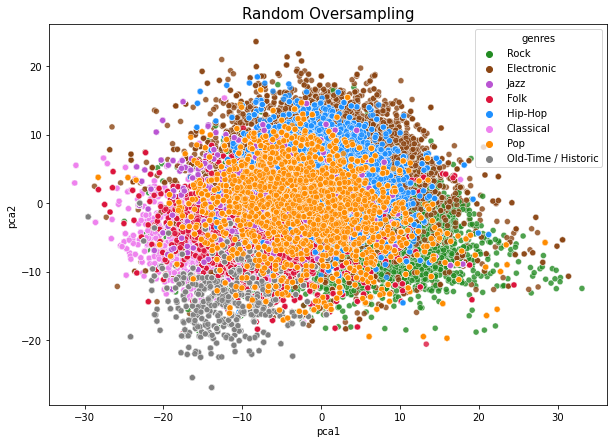

In [59]:
pca_2D(X_over, y_over, 'Random Oversampling')

In [60]:
y_over.value_counts()

7    9768
6    9768
5    9768
4    9768
3    9768
2    9768
1    9768
0    9768
Name: genre_top, dtype: int64

#### A.2.5) SMOTE

In [61]:
smote_over = SMOTE()
X_smote, y_smote = smote_over.fit_resample(X, y)
X_smote.shape, y_smote.shape

((78144, 154), (78144,))

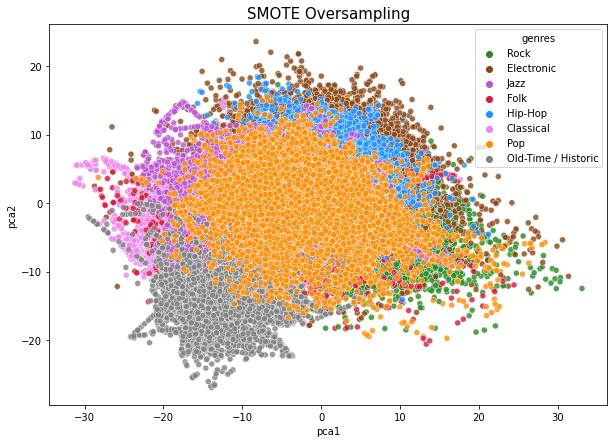

In [62]:
pca_2D(X_smote, y_smote, 'SMOTE Oversampling')

In [63]:
y_smote.value_counts()

7    9768
6    9768
5    9768
4    9768
3    9768
2    9768
1    9768
0    9768
Name: genre_top, dtype: int64

#### A.2.6) K-Means SMOTE

In [64]:
ksmote = KMeansSMOTE(random_state=42, sampling_strategy='not majority',kmeans_estimator=90, k_neighbors=5, cluster_balance_threshold=0.2)
X_ksmote, y_ksmote = ksmote.fit_resample(X, y)

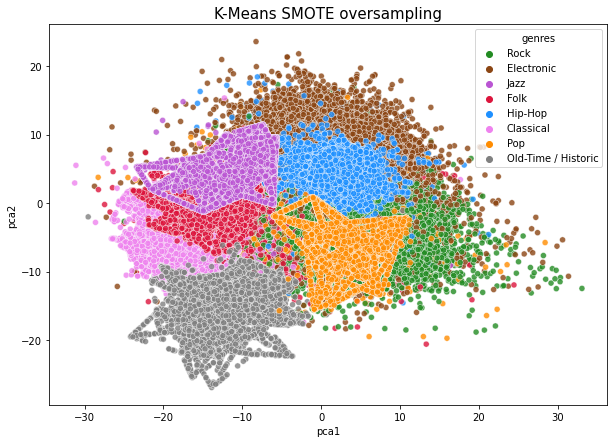

In [65]:
pca_2D(X_ksmote, y_ksmote, "K-Means SMOTE oversampling")

In [66]:
y_ksmote.value_counts()

1    9806
2    9784
3    9778
0    9773
6    9770
5    9770
7    9768
4    9768
Name: genre_top, dtype: int64

#### A.2.7) ADASYN

In [67]:
adasyn = ADASYN()
X_adasyn, y_adasyn = adasyn.fit_resample(X, y)

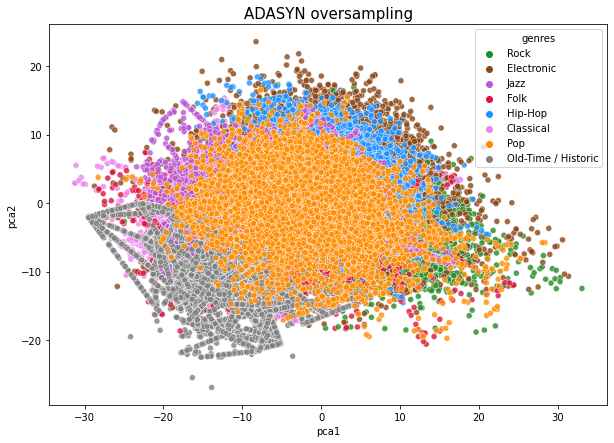

In [68]:
pca_2D(X_adasyn, y_adasyn, "ADASYN oversampling")

In [69]:
y_adasyn.value_counts()

2    10108
3     9791
5     9784
7     9768
0     9742
4     9729
1     9455
6     9451
Name: genre_top, dtype: int64

## A.3) Decision tree
### A.3.1) Random Search 

In [42]:
from sklearn.model_selection import RandomizedSearchCV

In [71]:
data =[(X_under,y_under),(X_cnn,y_cnn),(X_tomek, y_tomek),(X_over,y_over),
       (X_smote,y_smote),(X_ksmote,y_ksmote),(X_adasyn,y_adasyn)]

titles =['undersampling','condensed NN','Tomek links',
         'oversampling','SMOTE','K-means SMOTE','ADASYN' ]

params = {"criterion":["gini", "entropy"],
         "max_depth":[x for x in range(4,10)],
         "min_samples_split": [x for x in range(4,50)],
         "min_samples_leaf": [x for x in range(10,55)]}

for model, title in zip(data,titles):
    dt = DecisionTreeClassifier()
    clf = RandomizedSearchCV(estimator=dt, param_distributions=params, cv=5, n_iter=50, random_state=42,
                             verbose=True, return_train_score=True, )
    search = clf.fit(model[0], model[1])
    print(f"*******{title}*******")
    print(search.best_params_)
    print(f"accuracy validation: {search.best_score_}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  1.6min finished


*******undersampling*******
{'min_samples_split': 14, 'min_samples_leaf': 16, 'max_depth': 6, 'criterion': 'gini'}
accuracy validation: 0.48860199676915333
Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:   28.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


*******condensed NN*******
{'min_samples_split': 30, 'min_samples_leaf': 14, 'max_depth': 7, 'criterion': 'gini'}
accuracy validation: 0.42362869198312236
Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed: 16.6min finished


*******Tomek links*******
{'min_samples_split': 5, 'min_samples_leaf': 29, 'max_depth': 8, 'criterion': 'entropy'}
accuracy validation: 0.6174842998389181
Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed: 30.0min finished


*******oversampling*******
{'min_samples_split': 15, 'min_samples_leaf': 22, 'max_depth': 9, 'criterion': 'entropy'}
accuracy validation: 0.6723868820116987
Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed: 59.9min finished


*******SMOTE*******
{'min_samples_split': 15, 'min_samples_leaf': 22, 'max_depth': 9, 'criterion': 'entropy'}
accuracy validation: 0.6554053884754774
Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed: 58.2min finished


*******K-means SMOTE*******
{'min_samples_split': 15, 'min_samples_leaf': 22, 'max_depth': 9, 'criterion': 'entropy'}
accuracy validation: 0.8543694326881534
Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed: 59.4min finished


*******ADASYN*******
{'min_samples_split': 15, 'min_samples_leaf': 22, 'max_depth': 9, 'criterion': 'entropy'}
accuracy validation: 0.5369018104685812


###  A.3.2) Retrain Models : Unbalanced vs Balanced

In [72]:
data_training =[(X,y),(X_under,y_under),(X_cnn,y_cnn),(X_tomek, y_tomek),(X_over,y_over),
       (X_smote,y_smote),(X_ksmote,y_ksmote),(X_adasyn,y_adasyn)]

titles =['unbalanced','undersampling','condensed NN','Tomek links',
         'oversampling','SMOTE','K-means SMOTE','ADASYN' ]

models ={
    
    'unbalanced':DecisionTreeClassifier(criterion= 'gini',max_depth=10,
                                        min_samples_leaf= 45, min_samples_split=5),
   
    "undesampling":DecisionTreeClassifier(criterion= 'entropy',max_depth=6,
                                        min_samples_leaf= 16, min_samples_split=14),
    
    "condensed NN":DecisionTreeClassifier(criterion= 'gini',max_depth=7,
                                        min_samples_leaf= 14, min_samples_split=30),
    
    "Tomek links":DecisionTreeClassifier(criterion= 'gini',max_depth=8,
                                        min_samples_leaf= 29, min_samples_split=5),
    
    "oversampling":DecisionTreeClassifier(criterion= 'entropy',max_depth=9,
                                        min_samples_leaf= 22, min_samples_split=15),
    
    
    "SMOTE":DecisionTreeClassifier(criterion= 'gini',max_depth=9,
                                        min_samples_leaf= 22, min_samples_split=15),
    
    "k-means SMOTE":DecisionTreeClassifier(criterion= 'gini',max_depth=9,
                                        min_samples_leaf= 22, min_samples_split=15),
    
    "ADASYN":DecisionTreeClassifier(criterion= 'entropy',max_depth=9,
                                        min_samples_leaf= 22, min_samples_split=15)
}

roc_curves ={} #stores roc curves for each model
fpr_tpr = [] #stores false positive and true positive rates for each models
f1_scores_minc =[] # stores f1 score of minority class for each model
precision_minc=[]
recall_minc=[]

for model,data,title in zip(models, data_training, titles):
    dt = models[model]
    dt.fit(data[0],data[1])
    y_pred = dt.predict(X_test)

    # computes roc curve for each classifier
    #y_score = dt.predict_proba(X_test)
    #fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
    #roc_auc = auc(fpr, tpr)

    # saves the roc curve of each classifier in the dictionary roc_curves
    #roc_curves[title] = roc_auc
    # saves the fpr and tpr of each classifier in a list of tuples "fpr_tpr"
    #fpr_tpr.append((fpr,tpr))
    
    # save f1 score of minority class 
    f1_scores_minc.append(f1_score(y_test, y_pred, average=None)[0])
    #save recall score of minority class
    recall_minc.append(recall_score(y_test, y_pred, average=None)[0])
    # save precision score of minority class
    precision_minc.append(precision_score(y_test, y_pred, average=None)[0])
    
    print(f"*** {title} classification ***")
    print('Accuracy %s' % accuracy_score(y_test, y_pred))
    print('F1-score %s\n' % f1_score(y_test, y_pred, average=None))
    print('Recall %s' % recall_score(y_test, y_pred, average=None))
    print('Precision %s' % precision_score(y_test, y_pred,average=None))
    print(classification_report(y_test, y_pred))

*** unbalanced classification ***
Accuracy 0.6184578505793048
F1-score [0.6058906  0.60372581 0.44090631 0.4442138  0.07619048 0.72964169
 0.03894298 0.75339417]

Recall [0.59833795 0.63605183 0.4379562  0.4139265  0.04848485 0.67878788
 0.02140673 0.80845474]
Precision [0.61363636 0.57452668 0.44389642 0.47928331 0.17777778 0.78873239
 0.21538462 0.70535528]
              precision    recall  f1-score   support

           0       0.61      0.60      0.61       361
           1       0.57      0.64      0.60      2624
           2       0.44      0.44      0.44       822
           3       0.48      0.41      0.44      1034
           4       0.18      0.05      0.08       165
           5       0.79      0.68      0.73       165
           6       0.22      0.02      0.04       654
           7       0.71      0.81      0.75      4187

    accuracy                           0.62     10012
   macro avg       0.50      0.46      0.46     10012
weighted avg       0.58      0.62      0.5

# B) Feature Selection: Multigenre Classification
## B.1) Compute Feature Selection and plot distribution in 2D

In [12]:
from sklearn.feature_selection import SelectFromModel

In [13]:
# compute feature selection from decision tree model
sfm = SelectFromModel(DecisionTreeClassifier())
X_sfm = sfm.fit_transform(scaled_features,labels)

In [14]:
print(f"Original number of features: {scaled_features.shape[1]}\nAfter Feature Selector: {X_sfm.shape[1]}\nNumber of Features detached: {scaled_features.shape[1]-X_sfm.shape[1]}")

Original number of features: 518
After Feature Selector: 99
Number of Features detached: 419


In [15]:
# split data in development and internal test
X, X_test, y, y_test = train_test_split(X_sfm, labels, test_size=0.30, random_state=42, stratify=labels)

In [16]:
# development set shape
X.shape, y.shape

((23361, 99), (23361,))

In [17]:
# internal test shape
X_test.shape, y_test.shape

((10012, 99), (10012,))

In [18]:
print(f"____Legend_____\n0: Classical\n1: Electronic\n2: Folk\n3: Hip-Hop\n4: Jazz\n5: Old-Time / Historic\n6: Pop\
\n7: Rock'\n")

print('Class distribution before balancing after splitting in train test')
pd.concat(
    [y.value_counts(),
                round(y.value_counts(normalize=True).mul(100),2)],
                axis=1,
                keys=('counts','percentage (%)')
)

____Legend_____
0: Classical
1: Electronic
2: Folk
3: Hip-Hop
4: Jazz
5: Old-Time / Historic
6: Pop
7: Rock'

Class distribution before balancing after splitting in train test


counts  percentage (%)
7    9768           41.81
1    6124           26.21
3    2413           10.33
2    1919            8.21
6    1526            6.53
0     842            3.60
4     385            1.65
5     384            1.64

In [19]:
print(f"____Legend_____\n0: Classical\n1: Electronic\n2: Folk\n3: Hip-Hop\n4: Jazz\n5: Old-Time / Historic\n6: Pop\
\n7: Rock'\n")

print('Class distribution before balancing after splitting in test test')
pd.concat(
    [y_test.value_counts(),
                round(y_test.value_counts(normalize=True).mul(100),2)],
                axis=1,
                keys=('counts','percentage (%)')
)

____Legend_____
0: Classical
1: Electronic
2: Folk
3: Hip-Hop
4: Jazz
5: Old-Time / Historic
6: Pop
7: Rock'

Class distribution before balancing after splitting in test test


counts  percentage (%)
7    4187           41.82
1    2624           26.21
3    1034           10.33
2     822            8.21
6     654            6.53
0     361            3.61
5     165            1.65
4     165            1.65

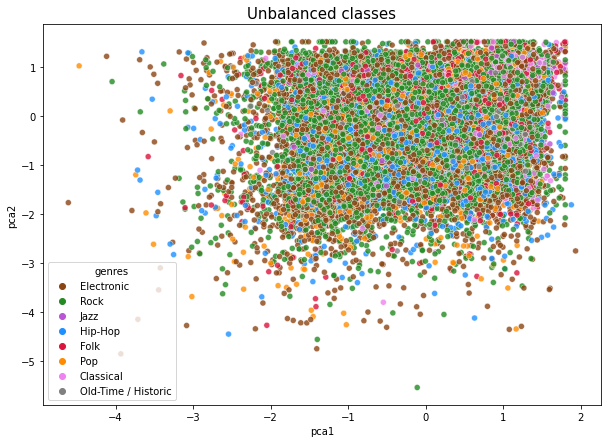

In [20]:
pca_2D(X, y,'Unbalanced classes')

## B.2) Imbalanced learning
#### B.2.1) Undersampling - Random

In [21]:
under_sample = RandomUnderSampler(random_state=42)
# Store under-sampled data
X_under, y_under = under_sample.fit_resample(X,y)

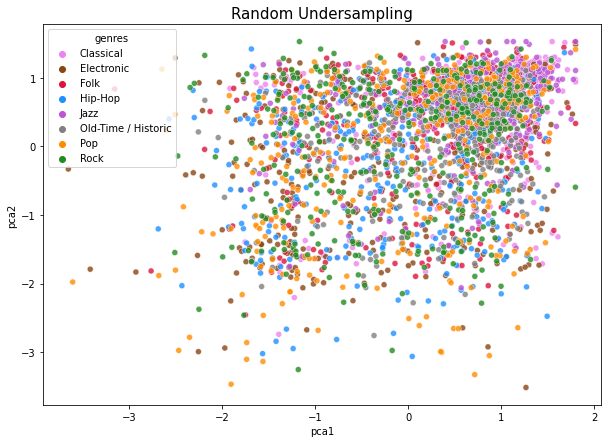

In [22]:
pca_2D(X_under,y_under,'Random Undersampling')

In [23]:
y_under.value_counts()

7    384
5    384
3    384
1    384
6    384
4    384
2    384
0    384
Name: genre_top, dtype: int64

#### B.2.2) Condensed Nearest Neighbor (CNN) *

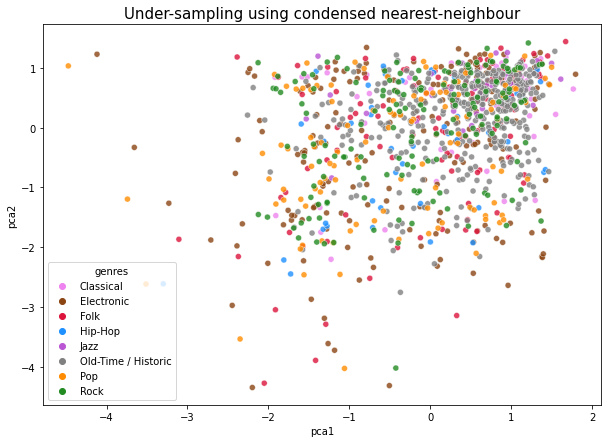

In [24]:
# Apply Condensed Nearest Neighbours
cnn = CondensedNearestNeighbour()
X_cnn, y_cnn = cnn.fit_resample(X, y)
#X_res_vis = pca.transform(X_resampled)
pca_2D(X_cnn,y_cnn,'Under-sampling using condensed nearest-neighbour')

In [25]:
y_cnn.value_counts()

5    384
1    190
7    155
6    112
2    112
0     54
3     44
4     35
Name: genre_top, dtype: int64

#### B.2.3) Tomek's Link *

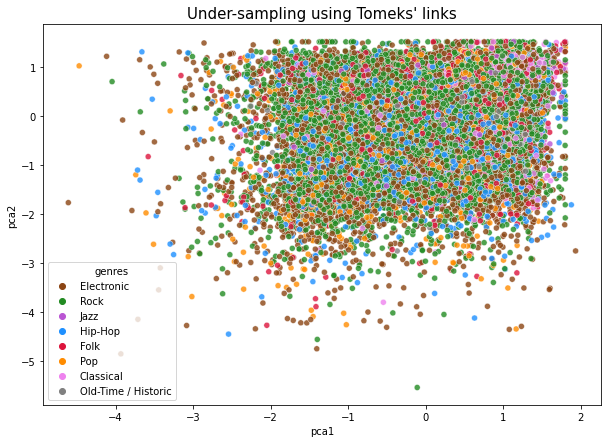

In [26]:
tomeks = TomekLinks()
X_tomek, y_tomek = tomeks.fit_resample(X, y)

pca_2D(X_tomek, y_tomek, 'Under-sampling using Tomeks\' links')

In [27]:
y_tomek.value_counts()

7    9624
1    5976
3    2322
2    1862
6    1435
0     836
5     384
4     362
Name: genre_top, dtype: int64

#### B.2.4) Oversampling - Random

In [28]:
over_sample = RandomOverSampler(sampling_strategy='not majority')
X_over, y_over = over_sample.fit_resample(X, y)
X_over.shape, y_over.shape

((78144, 99), (78144,))

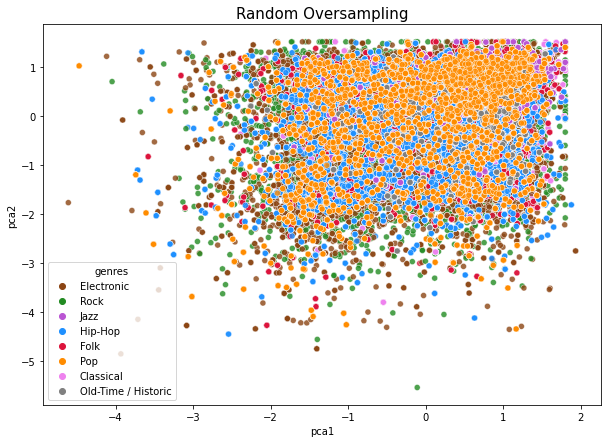

In [29]:
pca_2D(X_over, y_over, 'Random Oversampling')

In [30]:
y_over.value_counts()

7    9768
6    9768
5    9768
4    9768
3    9768
2    9768
1    9768
0    9768
Name: genre_top, dtype: int64

#### B.2.5) SMOTE

In [31]:
smote_over = SMOTE()
X_smote, y_smote = smote_over.fit_resample(X, y)
X_smote.shape, y_smote.shape

((78144, 99), (78144,))

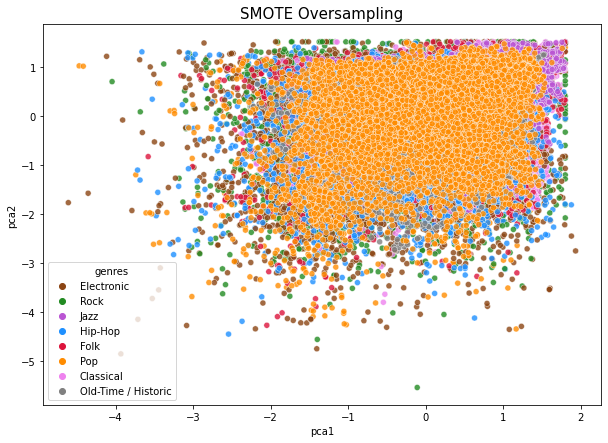

In [32]:
pca_2D(X_smote, y_smote, 'SMOTE Oversampling')

In [33]:
y_smote.value_counts()

7    9768
6    9768
5    9768
4    9768
3    9768
2    9768
1    9768
0    9768
Name: genre_top, dtype: int64

#### B.2.6) K-Means SMOTE

In [34]:
ksmote = KMeansSMOTE(random_state=42, sampling_strategy='not majority',kmeans_estimator=90, k_neighbors=5,cluster_balance_threshold=0)
X_ksmote, y_ksmote = ksmote.fit_resample(X, y)

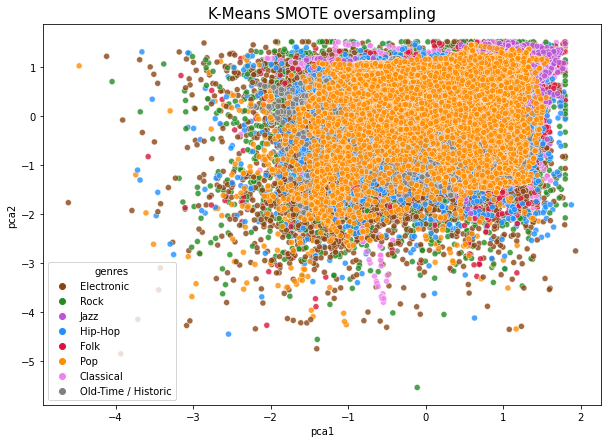

In [35]:
pca_2D(X_ksmote, y_ksmote, "K-Means SMOTE oversampling")

In [36]:
y_ksmote.value_counts()

1    9834
3    9808
2    9807
6    9806
0    9785
4    9777
5    9774
7    9768
Name: genre_top, dtype: int64

#### B.2.7) ADASYN

In [37]:
adasyn = ADASYN()
X_adasyn, y_adasyn = adasyn.fit_resample(X, y)

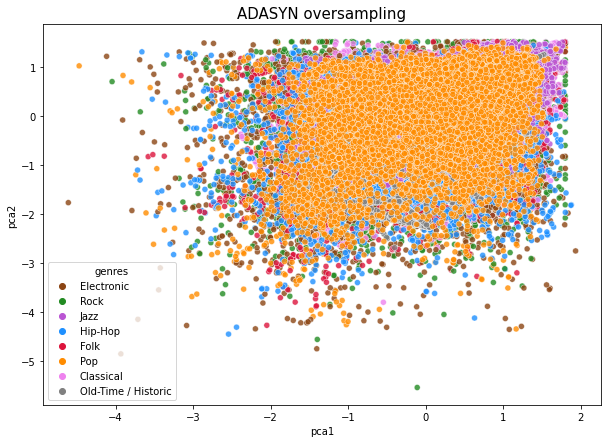

In [38]:
pca_2D(X_adasyn, y_adasyn, "ADASYN oversampling")

In [39]:
y_adasyn.value_counts()

2    10091
1     9954
6     9933
3     9906
0     9830
4     9817
5     9774
7     9768
Name: genre_top, dtype: int64

## B.3) Decision tree
### B.3.1)Random Search 

In [43]:
data =[(X_under,y_under),(X_cnn,y_cnn),(X_tomek, y_tomek),(X_over,y_over),
       (X_smote,y_smote),(X_ksmote,y_ksmote),(X_adasyn,y_adasyn)]

titles =['undersampling','condensed NN','Tomek links',
         'oversampling','SMOTE','K-means SMOTE','ADASYN' ]

params = {"criterion":["gini", "entropy"],
         "max_depth":[x for x in range(4,10)],
         "min_samples_split": [x for x in range(4,50)],
         "min_samples_leaf": [x for x in range(10,55)]}

for model, title in zip(data,titles):
    dt = DecisionTreeClassifier()
    clf = RandomizedSearchCV(estimator=dt, param_distributions=params, cv=5, n_iter=50, random_state=42,
                             verbose=True, return_train_score=True, )
    search = clf.fit(model[0], model[1])
    print(f"*******{title}*******")
    print(search.best_params_)
    print(f"accuracy validation: {search.best_score_}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:   58.9s finished


*******undersampling*******
{'min_samples_split': 25, 'min_samples_leaf': 14, 'max_depth': 9, 'criterion': 'gini'}
accuracy validation: 0.5341760016948703
Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:   16.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


*******condensed NN*******
{'min_samples_split': 17, 'min_samples_leaf': 51, 'max_depth': 4, 'criterion': 'gini'}
accuracy validation: 0.47599881621781587
Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed: 10.3min finished


*******Tomek links*******
{'min_samples_split': 13, 'min_samples_leaf': 15, 'max_depth': 8, 'criterion': 'entropy'}
accuracy validation: 0.6514626101539751
Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed: 18.7min finished


*******oversampling*******
{'min_samples_split': 15, 'min_samples_leaf': 22, 'max_depth': 9, 'criterion': 'entropy'}
accuracy validation: 0.6857084076622277
Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed: 37.6min finished


*******SMOTE*******
{'min_samples_split': 15, 'min_samples_leaf': 22, 'max_depth': 9, 'criterion': 'entropy'}
accuracy validation: 0.6726813262142235
Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed: 36.2min finished


*******K-means SMOTE*******
{'min_samples_split': 41, 'min_samples_leaf': 41, 'max_depth': 9, 'criterion': 'entropy'}
accuracy validation: 0.7798983461907134
Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed: 37.6min finished


*******ADASYN*******
{'min_samples_split': 15, 'min_samples_leaf': 22, 'max_depth': 9, 'criterion': 'entropy'}
accuracy validation: 0.5459763754595641


# B.3.2) Retrain Models: Unbalanced vs Balanced

In [44]:
 data_training =[(X,y),(X_under,y_under),(X_cnn,y_cnn),(X_tomek, y_tomek),(X_over,y_over),
       (X_smote,y_smote),(X_ksmote,y_ksmote),(X_adasyn,y_adasyn)]

titles =['unbalanced','undersampling','condensed NN','Tomek links',
         'oversampling','SMOTE','K-means SMOTE','ADASYN' ]

models ={
    'unbalanced':DecisionTreeClassifier(criterion= 'gini',max_depth=8,
                                        min_samples_leaf= 5, min_samples_split=20),
   
    "undesampling":DecisionTreeClassifier(criterion= 'entropy',max_depth=9,
                                        min_samples_leaf= 14, min_samples_split=25),
    
    "condensed NN":DecisionTreeClassifier(criterion= 'gini',max_depth=4,
                                        min_samples_leaf= 51, min_samples_split=17),
    
    "Tomek links":DecisionTreeClassifier(criterion= 'gini',max_depth=8,
                                        min_samples_leaf= 15, min_samples_split=13),
    
    "oversampling":DecisionTreeClassifier(criterion= 'entropy',max_depth=9,
                                        min_samples_leaf= 22, min_samples_split=15),
    
    "SMOTE":DecisionTreeClassifier(criterion= 'gini',max_depth=9,
                                        min_samples_leaf= 22, min_samples_split=15),
    
    "k-means SMOTE":DecisionTreeClassifier(criterion= 'gini',max_depth=9,
                                        min_samples_leaf= 41, min_samples_split=41),
    
    "ADASYN":DecisionTreeClassifier(criterion= 'entropy',max_depth=9,
                                        min_samples_leaf= 22, min_samples_split=15)
}

roc_curves ={} #stores roc curves for each model
fpr_tpr = [] #stores false positive and true positive rates for each models
f1_scores_minc =[] # stores f1 score of minority class for each model
precision_minc=[]
recall_minc=[]

for model,data,title in zip(models, data_training, titles):
    dt = models[model]
    dt.fit(data[0],data[1])
    y_pred = dt.predict(X_test)

    # computes roc curve for each classifier
    #y_score = dt.predict_proba(X_test)
    #fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
    #roc_auc = auc(fpr, tpr)

    # saves the roc curve of each classifier in the dictionary roc_curves
    #roc_curves[title] = roc_auc
    # saves the fpr and tpr of each classifier in a list of tuples "fpr_tpr"
    #fpr_tpr.append((fpr,tpr))
    
    # save f1 score of minority class 
    f1_scores_minc.append(f1_score(y_test, y_pred, average=None)[0])
    # save recall score of minority class
    recall_minc.append(recall_score(y_test, y_pred, average=None)[0])
    # save precision score of minority class
    precision_minc.append(precision_score(y_test, y_pred, average=None)[0])
    
    print(f"*** {title} classification ***")
    print('Accuracy %s' % accuracy_score(y_test, y_pred))
    print('F1-score %s\n' % f1_score(y_test, y_pred, average=None))
    print('Recall %s' % recall_score(y_test, y_pred, average=None))
    print('Precision %s' % precision_score(y_test, y_pred,average=None))
    print(classification_report(y_test, y_pred))

*** unbalanced classification ***
Accuracy 0.6417299240910906
F1-score [0.6539075  0.63514719 0.46589447 0.43361884 0.01129944 0.79742765
 0.03651685 0.77099237]

Recall [0.56786704 0.67835366 0.44038929 0.39168279 0.00606061 0.75151515
 0.01987768 0.84427991]
Precision [0.77067669 0.59711506 0.49453552 0.48561151 0.08333333 0.84931507
 0.22413793 0.709412  ]
              precision    recall  f1-score   support

           0       0.77      0.57      0.65       361
           1       0.60      0.68      0.64      2624
           2       0.49      0.44      0.47       822
           3       0.49      0.39      0.43      1034
           4       0.08      0.01      0.01       165
           5       0.85      0.75      0.80       165
           6       0.22      0.02      0.04       654
           7       0.71      0.84      0.77      4187

    accuracy                           0.64     10012
   macro avg       0.53      0.46      0.48     10012
weighted avg       0.60      0.64      0.6